185
1


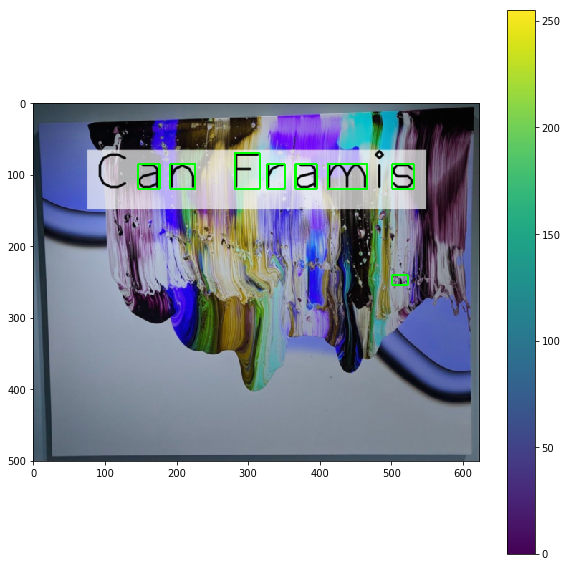

In [47]:
# -*- coding: utf-8 -*-

# Built-in modules
import logging
import os

# 3rd party modules
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import skimage

# Local modules
#import utils as ut
#import numpy as np

#img = cv2.imread('dataset/w5_devel_random/ima_000000.jpg')          # queryImage
img = cv2.imread('dataset/w5_BBDD_random/ima_000013.jpg') # trainImage

##################################
# Useful operations:

kernel = np.ones((3,3),np.uint8)
erosion = cv2.erode(img,kernel,iterations = 1)
dilation = cv2.dilate(img,kernel,iterations = 1)
opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
gradient = cv2.morphologyEx(img, cv2.MORPH_GRADIENT, kernel)
tophat = cv2.morphologyEx(img, cv2.MORPH_TOPHAT, kernel)
###################################

[im_h,im_w] = np.shape(img[:,:,0])
rgb = cv2.pyrDown(img)
small = cv2.cvtColor(rgb, cv2.COLOR_BGR2GRAY)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2,2))
grad = cv2.morphologyEx(small, cv2.MORPH_GRADIENT, kernel)

g2 = np.greater(grad,120)
g2 = g2.astype('uint8')

_, bw = cv2.threshold(grad, 0.0, 255.0, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9,1))
connected = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, kernel)

# using RETR_EXTERNAL instead of RETR_CCOMP

im_new, contours, hierarchy = cv2.findContours(connected.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
mask = np.zeros(bw.shape, dtype=np.uint8)

for idx in range(len(contours)):
    x, y, w, h = cv2.boundingRect(contours[idx])
    mask[y:y+h, x:x+w] = 0
    cv2.drawContours(mask, contours, idx, (255, 255, 255), -1)
    r = float(cv2.countNonZero(mask[y:y+h, x:x+w])) / (w * h)

    #if r > 0.45 and w > 8 and h > 8:
    if r > 0.3 and 200>w> 20 and 100>h> 12:
    #if r > 0.45 and w>im_w/4 and h>im_h/4:
        cv2.rectangle(rgb, (x, y), (x+w-1, y+h-1), (0, 255, 0), 2)

plt.figure(figsize=(10,10))
        
plt.imshow(rgb)


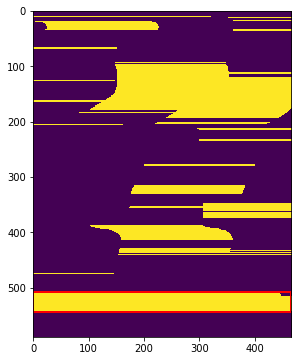

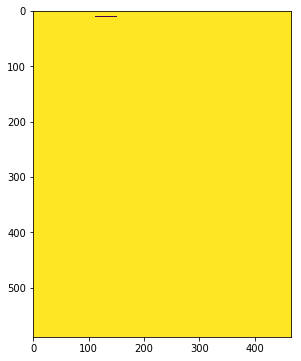

In [130]:
from skimage.measure import label, regionprops
from utils import get_files_from_dir
from utils import bboxes_to_file 
import matplotlib.patches as mpatches

def connected_components(mask0, area_min=None, area_max=None, ff_min=None, ff_max=None, fr_min=None, 
                         plot=False, fname=None, directory=None):

    label_image = label(mask0)
    bbox_list = []

    if plot==True:
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.imshow(mask0)

    mask = np.zeros(np.shape(mask0))
    
    for region in regionprops(label_image):
        minr, minc, maxr, maxc = region.bbox
        h = maxr - minr
        w = maxc - minc
        form_factor = w / h
        filling_ratio = region.filled_area / region.bbox_area
        
        # Filter by area:
        if area_min is not None and area_max is not None:
            if area_min <= region.bbox_area <= area_max:
                 minr, minc, maxr, maxc = region.bbox
            else:
                del(minr, minc, maxr, maxc)
                continue
                
        # Filter by form factor:
        if ff_min is not None and ff_max is not None:
            if ff_min < form_factor < ff_max:
                minr, minc, maxr, maxc = region.bbox
            else:
                del(minr, minc, maxr, maxc)
                continue

        # Filter by filling ratio:
        if fr_min is not None:
            if filling_ratio > fr_min:
                minr, minc, maxr, maxc = region.bbox
            else:
                del(minr, minc, maxr, maxc)
                continue
        
        bbox_list.append([minr, minc, maxr, maxc])
        mask[minr:maxr, minc:maxc] = 1

        if plot==True:

            rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                      fill=False, edgecolor='red', linewidth=2)
            ax.add_patch(rect)
        #plt.savefig('figures/filter_area_ff_fr_train.png')

        if fname is not None and directory is not None:
            bboxes_to_file(bbox_list, fname, directory, sign_types=None)

    return bbox_list, mask

img = cv2.imread('dataset/w5_BBDD_random/ima_000002.jpg') # trainImage

kernel = np.ones((3,3),np.uint8)
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gradient = cv2.morphologyEx(gray_img, cv2.MORPH_GRADIENT, kernel)

ret,thresh1 = cv2.threshold(gradient,150,255,cv2.THRESH_BINARY)
ret,thresh2 = cv2.threshold(gradient,60,255,cv2.THRESH_BINARY_INV)

kernel_open = np.ones((1,200),np.uint8)

dilation1 = cv2.dilate(thresh1,kernel_open,iterations = 1)
dilation2 = cv2.dilate(thresh2,kernel_open,iterations = 1)
        
prueba1, mask1 = connected_components(dilation1, area_min=10000, area_max = 5000000, ff_min=10 , ff_max=100 , plot=True)
prueba2, mask2 = connected_components(dilation2, area_min=10000, area_max = 5000000, ff_min=10 , ff_max=100, plot=True)


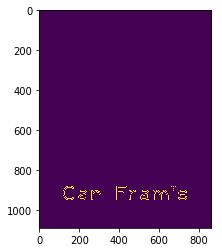

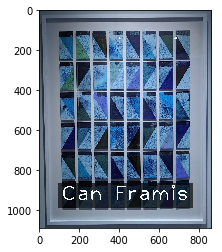

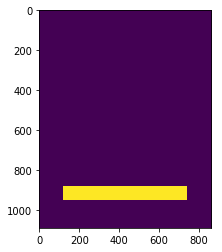

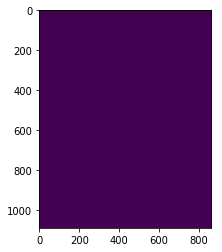

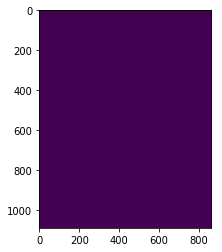

In [125]:
erosion1 = cv2.erode(mask1,kernel_open,iterations = 1)
plt.imshow(thresh1 * erosion1)
plt.show()

plt.imshow(img)
plt.show()

plt.imshow(erosion1)
plt.show()

erosion2 = cv2.erode(mask2,kernel_open,iterations = 1)
plt.imshow(thresh2 * erosion2)
plt.show()

plt.imshow(erosion2)
plt.show()


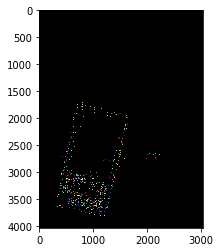

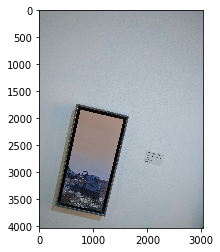

In [219]:
from __future__ import print_function
import cv2 as cv
import numpy as np
import argparse
import random as rng
rng.seed(12345)

def thresh_callback(val, image):
    threshold = val
    
    canny_output = cv.Canny(image, threshold, threshold * 2)
    
    
    _, contours, _ = cv.findContours(canny_output, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    
    # Find the rotated rectangles and ellipses for each contour
    minRect = [None]*len(contours)
    minEllipse = [None]*len(contours)
    for i, c in enumerate(contours):
        minRect[i] = cv.minAreaRect(c)
        if c.shape[0] > 5:
            minEllipse[i] = cv.fitEllipse(c)
    # Draw contours + rotated rects + ellipses
    
    drawing = np.zeros((canny_output.shape[0], canny_output.shape[1], 3), dtype=np.uint8)
    box_area = []
    for i, c in enumerate(contours):
    #i = 4208
    #c = contours[i]
        color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
        # contour
        #cv.drawContours(drawing, contours, i, color)
       
       # rotated rectangle

        box = cv.boxPoints(minRect[i])
        box_area.append(cv2.contourArea(box))
        #if cv2.contourArea(box) > 10000:
        box = np.intp(box) #np.intp: Integer used for indexing (same as C ssize_t; normally either int32 or int64)
        
        rect = cv2.minAreaRect(box)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        cv.drawContours(drawing, [box], 0, color)

    plt.imshow(drawing)
#    return box_area
    
#parser = argparse.ArgumentParser(description='Code for Creating Bounding rotated boxes and ellipses for contours tutorial.')
#parser.add_argument('--input', help='Path to input image.', default='../data/stuff.jpg')
#args = parser.parse_args()
#src = cv.imread(args.input)

img = cv2.imread('dataset/w5_devel_random/ima_000001.jpg')          # queryImage

src = img

# Convert image to gray and blur it
src_gray = cv.cvtColor(src, cv.COLOR_BGR2GRAY)
src_gray = cv.blur(src_gray, (3,3))

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2,2))
grad = cv2.morphologyEx(src_gray, cv2.MORPH_GRADIENT, kernel)

_, bw = cv2.threshold(grad, 0.0, 255.0, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9,1))
connected = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, kernel)


source_window = 'Source'
cv.namedWindow(source_window)

max_thresh = 255
thresh = 200 # initial threshold
cv.createTrackbar('Canny Thresh:', source_window, thresh, max_thresh, thresh_callback)

barea = thresh_callback(thresh, connected)

plt.figure()
plt.imshow(src)

error: OpenCV(3.4.2) /io/opencv/modules/imgproc/src/convhull.cpp:137: error: (-215:Assertion failed) total >= 0 && (depth == 5 || depth == 4) in function 'convexHull'


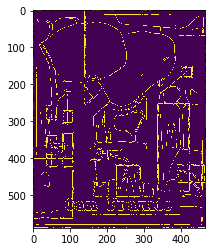

In [217]:
threshold = 150

canny_output = cv.Canny(image, threshold, threshold * 2)
plt.imshow((canny_output))
rect = cv2.minAreaRect(canny_output)
box = cv2.boxPoints(rect)
box = np.int0(box)
cv2.drawContours(img,[box],0,(0,0,255),2)

In [29]:
import utils as ut

gt = [[0, [-1]], [1, [-1]], [2, [115]], [3, [-1]], [4, [-1]], [5, [99]], [6, [-1]], [7, [89]], [8, [19]], 
      [9, [85]], [10, [90]], [11, [121, 117]], [12, [-1]], [13, [-1]], [14, [130]], [15, [6, 84]], 
      [16, [35, 48, 52]], [17, [118]], [18, [-1]], [19, [-1]], [20, [-1]], [21, [-1]], [22, [60]], 
      [23, [119, 128]], [24, [-1]], [25, [47]], [26, [-1]], [27, [41]], [28, [-1]], [29, [126, 123]]]

dbn = '../dataset/BBDD_W4/'
qn = '../dataset/query_devel_W4/'

dict_db = ut.get_files_from_dir(dbn)
dict_q = ut.get_files_from_dir(qn)

dict_db = np.sort(dict_db)
dict_q = np.sort(dict_q)

#print(dict_q)
for v in gt:
    if v[1] != [-1]:
        
        for v_db in v[1]:

            #print(dict_q[v[0]])
            q_name = os.path.join(qn, dict_q[v[0]])
            db_name = os.path.join(dbn,dict_db[v_db])
            
            q = cv.imread(q_name)
            db = cv.imread(db_name)
            
            #plt.imshow(q)
            #plt.imshow(db)
            #plt.show()
            '''
            fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True)
            ax = axs[0]
            ax.imshow(q)
            ax = axs[1]
            ax.imshow(db)
            '''
            orb = cv.ORB_create()

            # find the keypoints and descriptors with ORB
            kp1, des1 = orb.detectAndCompute(q,None)
            kp2, des2 = orb.detectAndCompute(db,None)


            # create BFMatcher object
            bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
            # Match descriptors.
            matches = bf.match(des1,des2)
            # Sort them in the order of their distance.
            matches = sorted(matches, key = lambda x:x.distance)

            n_matches = 10

            dist = []
            for m in matches[:n_matches]:
                dist.append(m.distance)

            sqrt_sum = np.sum(np.array(dist)**2) / n_matches
            
            #if sqrt_sum > 1000:
            print(q_name, db_name)
            print(sqrt_sum)



2018-11-02 12:24:21,980 - utils - DEBUG - Getting files in '/home/agus/repos/Team5/image_retrieval/dataset/BBDD_W4'
2018-11-02 12:24:21,984 - utils - DEBUG - Retrieving 131 files from '/home/agus/repos/Team5/image_retrieval/dataset/BBDD_W4'
2018-11-02 12:24:21,985 - utils - DEBUG - Getting files in '/home/agus/repos/Team5/image_retrieval/dataset/query_devel_W4'
2018-11-02 12:24:21,987 - utils - DEBUG - Retrieving 30 files from '/home/agus/repos/Team5/image_retrieval/dataset/query_devel_W4'


../dataset/query_devel_W4/ima_000002.jpg ../dataset/BBDD_W4/ima_000115.jpg
186.2
../dataset/query_devel_W4/ima_000005.jpg ../dataset/BBDD_W4/ima_000099.jpg
7.5
../dataset/query_devel_W4/ima_000007.jpg ../dataset/BBDD_W4/ima_000089.jpg
697.3
../dataset/query_devel_W4/ima_000008.jpg ../dataset/BBDD_W4/ima_000019.jpg
38.3
../dataset/query_devel_W4/ima_000009.jpg ../dataset/BBDD_W4/ima_000085.jpg
251.6
../dataset/query_devel_W4/ima_000010.jpg ../dataset/BBDD_W4/ima_000090.jpg
156.4
../dataset/query_devel_W4/ima_000011.jpg ../dataset/BBDD_W4/ima_000121.jpg
432.6
../dataset/query_devel_W4/ima_000011.jpg ../dataset/BBDD_W4/ima_000117.jpg
409.4
../dataset/query_devel_W4/ima_000014.jpg ../dataset/BBDD_W4/ima_000130.jpg
276.8
../dataset/query_devel_W4/ima_000015.jpg ../dataset/BBDD_W4/ima_000006.jpg
34.1
../dataset/query_devel_W4/ima_000015.jpg ../dataset/BBDD_W4/ima_000084.jpg
3.8
../dataset/query_devel_W4/ima_000016.jpg ../dataset/BBDD_W4/ima_000035.jpg
16.2
../dataset/query_devel_W4/ima_00001

# SIFT

2018-11-02 12:47:12,941 - matplotlib.axes._base - DEBUG - update_title_pos
2018-11-02 12:47:13,263 - matplotlib.axes._base - DEBUG - update_title_pos
2018-11-02 12:47:13,299 - matplotlib.axes._base - DEBUG - update_title_pos
2018-11-02 12:47:13,327 - matplotlib.axes._base - DEBUG - update_title_pos


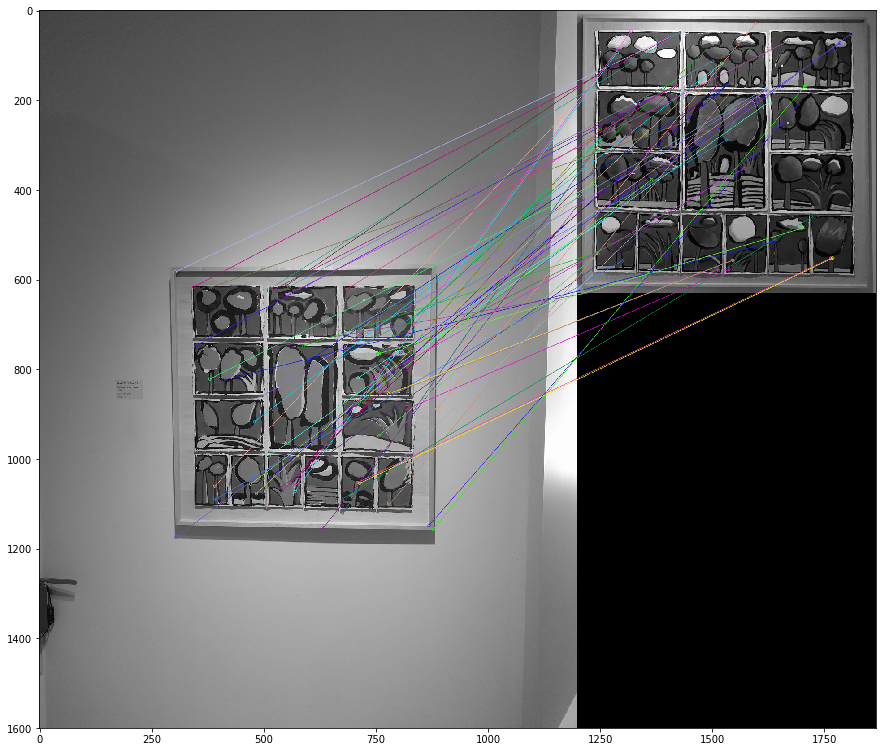

'\ndef compute_sift_descriptor(des1, des2, metric, thresh):\n    \n    # BFMatcher with default params\n    bf = cv.BFMatcher()\n    matches = bf.knnMatch(des1,des2, k=2)\n\n    # Apply ratio test\n    good = []\n    for m,n in matches:\n        if m.distance < metric*n.distance:\n            good.append([m])\n            \n    return(len(good)>thresh)\n\nprueba = compute_sift_descriptor(des1, des2, 0.5, 50)\n\nprint(prueba)\n'

In [46]:


img1 = cv.imread('../dataset/query_devel_W4/ima_000025.jpg',0)          # queryImage
#img2 = cv.imread('../dataset/BBDD_W4/ima_000035.jpg',0) # trainImage
#img2 = cv.imread('../dataset/BBDD_W4/ima_000048.jpg',0) # trainImage
img2 = cv.imread('../dataset/BBDD_W4/ima_000047.jpg',0) # trainImage

# Initiate SIFT detector
sift = cv.xfeatures2d.SIFT_create(10000)

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)


# BFMatcher with default params
bf = cv.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.5*n.distance:
        good.append([m])
        
# cv2.drawMatchesKnn expects list of lists as matches.
img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=2)

#cv.imwrite('sift_25_47_fail.png', img3)


plt.figure(figsize=(15,15))
plt.imshow(img3),plt.show()
  
'''
def compute_sift_descriptor(des1, des2, metric, thresh):
    
    # BFMatcher with default params
    bf = cv.BFMatcher()
    matches = bf.knnMatch(des1,des2, k=2)

    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < metric*n.distance:
            good.append([m])
            
    return(len(good)>thresh)

prueba = compute_sift_descriptor(des1, des2, 0.5, 50)

print(prueba)
'''

In [ ]:
print(len(good))

In [12]:
import utils as ut

gt = [[0, [-1]], [1, [-1]], [2, [115]], [3, [-1]], [4, [-1]], [5, [99]], [6, [-1]], [7, [89]], [8, [19]], [9, [85]], [10, [90]], [11, [121, 117]], [12, [-1]], [13, [-1]], [14, [130]], [15, [6, 84]], [16, [35, 48, 52]], [17, [118]], [18, [-1]], [19, [-1]], [20, [-1]], [21, [-1]], [22, [60]], [23, [119, 128]], [24, [-1]], [25, [47]], [26, [-1]], [27, [41]], [28, [-1]], [29, [126, 123]]]

dbn = '../dataset/BBDD_W4/'
qn = '../dataset/query_devel_W4/'

dict_db = ut.get_files_from_dir(dbn)
dict_q = ut.get_files_from_dir(qn)

dict_db = np.sort(dict_db)
dict_q = np.sort(dict_q)

for v in gt:
    if v[1] != [-1]:
        
        for v_db in v[1]:

            q_name = os.path.join(qn, dict_q[v[0]])
            db_name = os.path.join(dbn,dict_db[v_db])
            
            #print(q_name, db_name)
            
            q = cv.imread(q_name)
            db = cv.imread(db_name)
            '''
            # Initiate SIFT detector
            sift = cv.xfeatures2d.SIFT_create(10000)

            # find the keypoints and descriptors with SIFT
            kp1, des1 = sift.detectAndCompute(q,None)
            kp2, des2 = sift.detectAndCompute(db,None)

            # BFMatcher with default params
            bf = cv.BFMatcher()
            matches = bf.knnMatch(des1,des2, k=2)
            '''
            
            # Initiate SURF detector
            surf = cv.xfeatures2d.SURF_create(5000)

            # find the keypoints and descriptors with SIFT
            kp1, des1 = surf.detectAndCompute(q,None)
            kp2, des2 = surf.detectAndCompute(db,None)
            

            # BFMatcher with default params
            bf = cv.BFMatcher()
            matches = bf.knnMatch(des1,des2, k=2)
        
            # Apply ratio test
            good = []
            for m,n in matches:
                if m.distance < 0.5*n.distance:
                    good.append([m])
            
            if len(good)<10:
                print(q_name, db_name)
                print(len(good))

            

2018-11-02 11:55:22,957 - utils - DEBUG - Getting files in '/home/agus/repos/Team5/image_retrieval/dataset/BBDD_W4'
2018-11-02 11:55:22,961 - utils - DEBUG - Retrieving 131 files from '/home/agus/repos/Team5/image_retrieval/dataset/BBDD_W4'
2018-11-02 11:55:22,962 - utils - DEBUG - Getting files in '/home/agus/repos/Team5/image_retrieval/dataset/query_devel_W4'
2018-11-02 11:55:22,963 - utils - DEBUG - Retrieving 30 files from '/home/agus/repos/Team5/image_retrieval/dataset/query_devel_W4'


../dataset/query_devel_W4/ima_000002.jpg ../dataset/BBDD_W4/ima_000115.jpg
6
../dataset/query_devel_W4/ima_000007.jpg ../dataset/BBDD_W4/ima_000089.jpg
0
../dataset/query_devel_W4/ima_000017.jpg ../dataset/BBDD_W4/ima_000118.jpg
7
../dataset/query_devel_W4/ima_000025.jpg ../dataset/BBDD_W4/ima_000047.jpg
0
../dataset/query_devel_W4/ima_000029.jpg ../dataset/BBDD_W4/ima_000123.jpg
5


# SURF

2018-11-02 12:58:55,254 - matplotlib.axes._base - DEBUG - update_title_pos


(2075, 2)


2018-11-02 12:58:55,578 - matplotlib.axes._base - DEBUG - update_title_pos
2018-11-02 12:58:55,612 - matplotlib.axes._base - DEBUG - update_title_pos
2018-11-02 12:58:55,634 - matplotlib.axes._base - DEBUG - update_title_pos


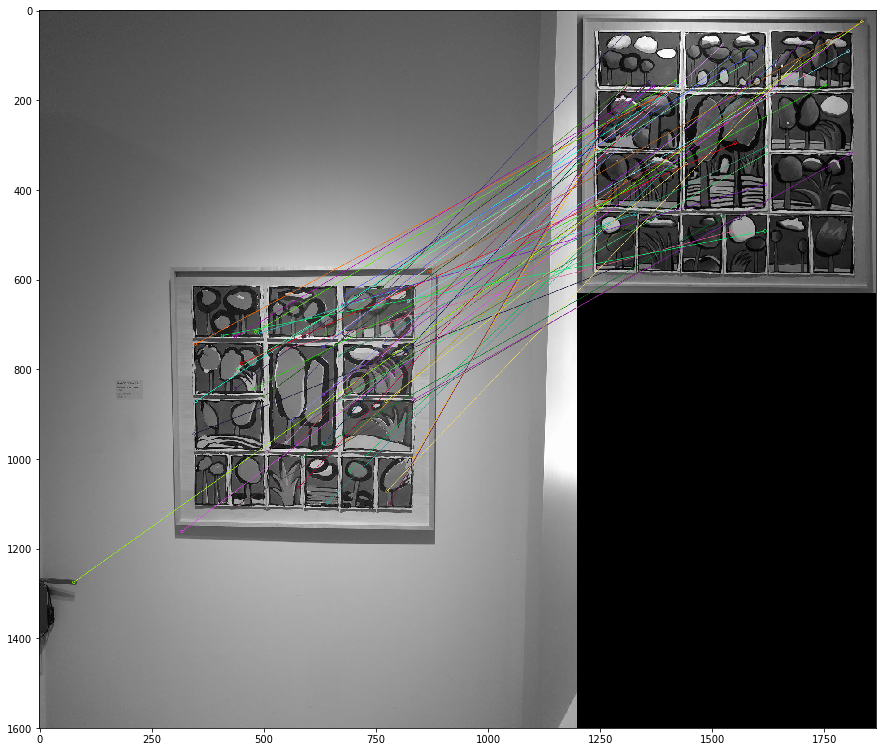

(<matplotlib.image.AxesImage at 0x7f1108efb438>, None)

In [75]:


img1 = cv.imread('../dataset/query_devel_W4/ima_000025.jpg',0)          # queryImage
#img2 = cv.imread('../dataset/BBDD_W4/ima_000035.jpg',0) # trainImage
#img2 = cv.imread('../dataset/BBDD_W4/ima_000048.jpg',0) # trainImage
img2 = cv.imread('../dataset/BBDD_W4/ima_000047.jpg',0) # trainImage

# Initiate SIFT detector
surf = cv.xfeatures2d.SURF_create(1000)

# find the keypoints and descriptors with SIFT
kp1, des1 = surf.detectAndCompute(img1,None)
kp2, des2 = surf.detectAndCompute(img2,None)


# BFMatcher with default params
bf = cv.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])
        
# cv2.drawMatchesKnn expects list of lists as matches.
img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=2)
#img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,mdist,None,flags=2)

#cv.imwrite('surf_5_99_good.png', img3)
#cv.imwrite('surf_7_89_fail.png', img3)
#cv.imwrite('surf_8_19_good.png', img3)
#cv.imwrite('surf_15_6_good_mult.png', img3)
#cv.imwrite('surf_15_84_good_mult.png', img3)
#cv.imwrite('surf_17_118_fail.png', img3)
cv.imwrite('surf_25_47_fail.png', img3)

print(np.shape(matches))
plt.figure(figsize=(15,15))
plt.imshow(img3),plt.show()
  

In [ ]:
########
# SURF:
########

#img1 = cv.imread('../dataset/query_devel_W4/ima_000005.jpg',0)          # queryImage
#img2 = cv.imread('../dataset/BBDD_W4/ima_000099.jpg',0)                 # trainImage

# Initiate SIFT detector
#surf = cv.xfeatures2d.SURF_create(5000)

# find the keypoints and descriptors with SURF
#kp1, des1 = surf.detectAndCompute(img1,None)
#kp2, des2 = surf.detectAndCompute(img2,None)

def compute_surf_descriptor(des1, des2, metric, thresh):

    # Result: compute_sift_descriptor(des1, des2, 0.5, 5)
    # Metric < 0.5, Threshold NOT SO GOOD! The ratio algorith may not be the best... 

    # BFMatcher with default params
    bf = cv.BFMatcher()
    matches = bf.knnMatch(des1,des2, k=2)

    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < metric*n.distance:
            good.append([m])
            
    return(len(good)>=thresh)

    